### Import Packages

In [2]:
%matplotlib inline
import cv2
import pandas
import skimage
import scipy
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.filters import gaussian, median, rank
from skimage import img_as_float
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import disk, square
from IPython.display import display, HTML

### Read Image

In [3]:
im = io.imread('/Users/bramalingam/Desktop/BacteriaSingleSlice.tif')

### Preprocessing

/Users/bramalingam/Documents/Jupyter_Training/anaconda2/envs/my-r-env/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(-0.5, 455.5, 1019.5, -0.5)

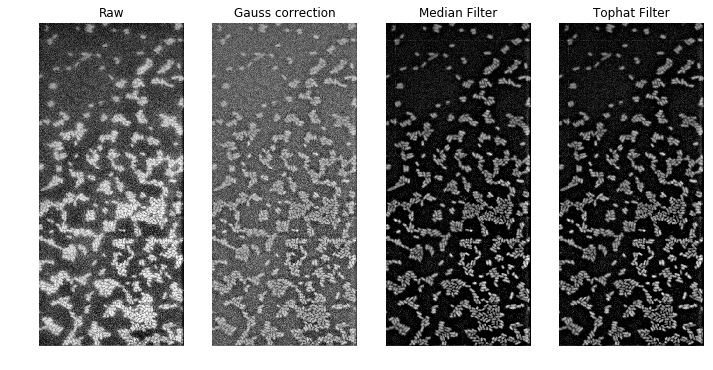

In [4]:
from skimage import exposure
import skimage
# from skimage import filter
plt.figure(figsize=(15, 10))
plt.subplot(1,5,1)

img_rescale = exposure.equalize_adapthist(im, clim=0.10)
plt.title('Raw')
plt.imshow(img_rescale, cmap='gray')
plt.axis('off')

image = img_as_float(img_rescale)
blurred = skimage.filters.gaussian(image, 10)
highpass = image - 0.8 * blurred
# sharp = image + highpass
plt.subplot(1,5,2)
plt.title('Gauss correction')
plt.imshow(highpass, cmap='gray')
plt.axis('off')

med = median(highpass)
plt.subplot(1,5,3)
plt.title('Median Filter')
plt.imshow(med, cmap='gray')
plt.axis('off')

selem = disk(55)
w_tophat = white_tophat(med, selem)
plt.subplot(1,5,4)
plt.title('Tophat Filter')
plt.imshow(w_tophat, cmap='gray')
plt.axis('off')


### Edge Detection and Post Processing

/Users/bramalingam/Documents/Jupyter_Training/anaconda2/envs/my-r-env/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


(-0.5, 455.5, 1019.5, -0.5)

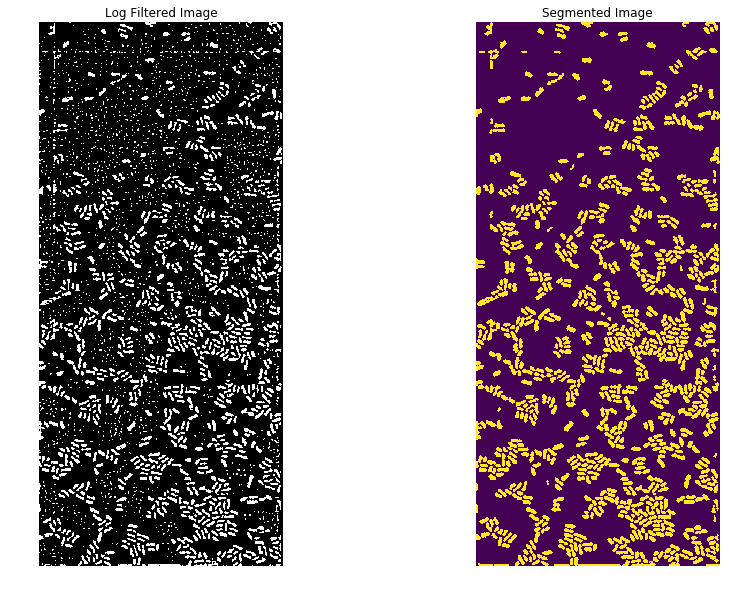

In [5]:
log_filter_kernel = np.array([[0.0064,0.0062,0.0050,0.0043,0.0050,0.0062,0.0064],
[0.0062,0.0033,-0.0014,-0.0037,-0.0014,0.0033,0.0062],
[0.0050,-0.0014,-0.0103,-0.0147,-0.0103,-0.0014,0.0050],
[0.0043,-0.0037,-0.0147,-0.0200,-0.0147,-0.0037,0.0043],
[0.0050,-0.0014,-0.0103,-0.0147,-0.0103,-0.0014,0.0050],
[0.0062,0.0033,-0.0014,-0.0037,-0.0014,0.0033,0.0062],
[0.0064,0.0062,0.0050,0.0043,0.0050,0.0062,0.0064]])

log_image = scipy.ndimage.convolve(w_tophat, log_filter_kernel, mode='constant', cval=0.0)
plt.figure(figsize=(30, 10))
plt.subplot(1,4,1)
plt.title('Log Filtered Image')
plt.imshow(log_image, cmap='gray')
plt.axis('off')

# Check this for connectivity and the type of thresh (it should be int or bool)
# seg = skimage.morphology.binary_closing(log_image, selem=disk(1))
seg = skimage.morphology.remove_small_objects(skimage.img_as_bool(log_image), 20, connectivity=8)
# Marker labelling
markers = skimage.morphology.label(seg)
markers = skimage.morphology.dilation(markers,disk(1))

plt.subplot(1,4,2)
plt.title('Segmented Image')
plt.imshow(markers>0)
plt.axis('off')

### Measure

In [6]:
def get_snr(props, cellid, background_size):

    dilimg = skimage.morphology.dilation(markers==cellid, disk(background_size))
    orgimg = markers==cellid

    diffimg = (dilimg - orgimg)
    bkg_coords = np.where(diffimg>0)

    bkg_int = []
    for idx, tempvar in enumerate(bkg_coords[0]):
        bkg_int.append(w_tophat[bkg_coords[0][idx],bkg_coords[1][idx]])

    return props[cellid].mean_intensity/np.mean(bkg_int)

def get_nearest_neighbours(markers, cellid, radius):

    dilimg = skimage.morphology.dilation(markers==cellid, disk(radius))
    coords = np.where(dilimg>0)
    
    idslist = []
    for idx, tempvar in enumerate(coords[0]):
        idslist.append(markers[coords[0][idx],coords[1][idx]])
        
    return len(np.unique(idslist))-2

props = skimage.measure.regionprops(markers, intensity_image=w_tophat)
props_dict={}
for idx, region in enumerate(props):
    
    props_dict[idx]={}
    props_dict[idx]['mean_intensity'] = region.mean_intensity
    props_dict[idx]['total_intensity']  = region.area * region.mean_intensity
    props_dict[idx]['area'] = region.area
    props_dict[idx]['major_axis_length'] = region.major_axis_length
    props_dict[idx]['minor_axis_length'] = region.minor_axis_length
    props_dict[idx]['snr'] = get_snr(props, idx, 1)
    props_dict[idx]['num_neighbours'] = get_nearest_neighbours(markers, idx, 5)
    
props_df = pandas.DataFrame.from_dict(props_dict, orient='index')
display(HTML(props_df.to_html( escape=False)))

/Users/bramalingam/Documents/Jupyter_Training/anaconda2/envs/my-r-env/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  


,minor_axis_length,area,total_intensity,num_neighbours,snr,mean_intensity,major_axis_length
0,11.064669,153,8641.0,927,1.045938,56.477124,21.256137
1,10.022926,80,1905.0,0,0.959077,23.812500,15.298969
2,12.082121,187,11768.0,0,5.736757,62.930481,31.161662
3,12.530186,202,9540.0,2,1.139543,47.227723,27.423402
4,7.461941,162,10494.0,0,3.256492,64.777778,30.674916
5,6.583336,57,4369.0,1,1.998364,76.649123,11.378641
6,7.515692,97,6104.0,2,1.093341,62.927835,16.964195
7,5.594489,78,5192.0,2,1.782107,66.564103,20.379556
8,9.547373,103,5695.0,2,0.997774,55.291262,13.994508
9,10.074327,123,7496.0,0,2.523365,60.943089,16.222164


### Plot Correlation

Text(0,0.5,u'snr')

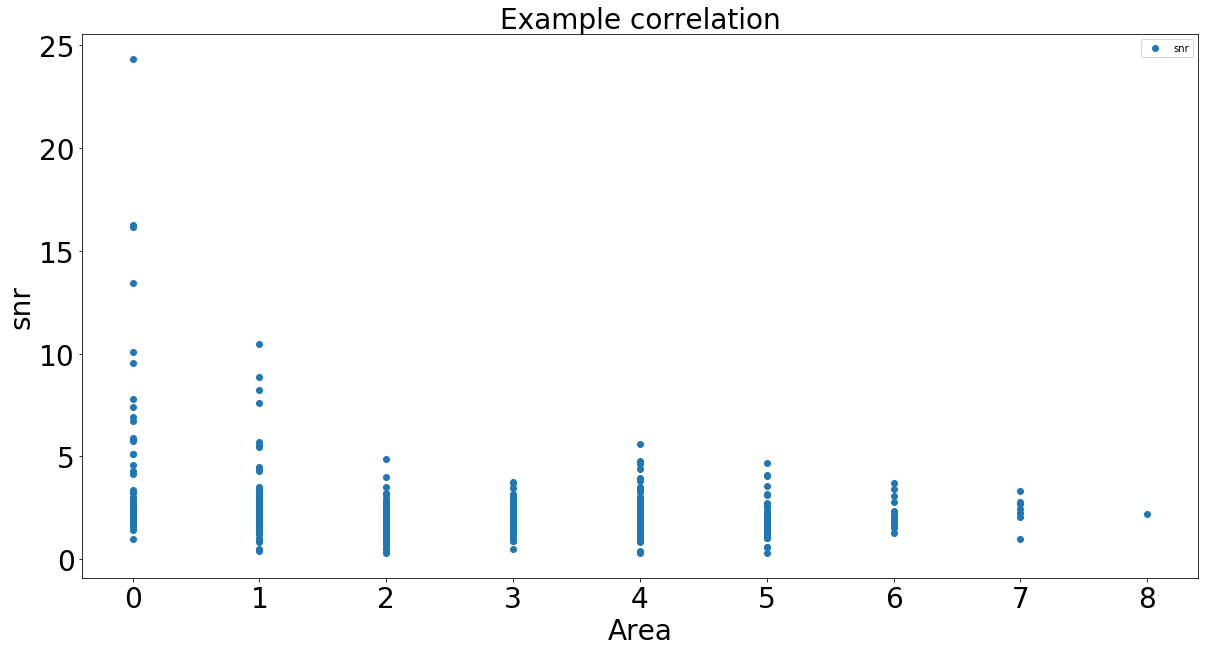

In [215]:
props_df = props_df.drop(props_df.index[0])
ax = props_df.plot(x='num_neighbours', y='snr', style='o', figsize=(20, 10), fontsize=28)
ax.set_title('Example correlation', fontsize=28)
ax.set_xlabel("Area", fontsize=28)
ax.set_ylabel("snr", fontsize=28)